In [2]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./trajopt/constraint.jl")
include("./trajopt/costfunction.jl")
include("./trajopt/scaling.jl")
include("./trajopt/scp.jl")
include("./trajopt/discretize.jl")
using Plots

In [3]:
ix = 12
iu = 4
N = 15
dynamics = QuadrotorDynamics()

QuadrotorDynamics(12, 4, 9, 7, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.325, 9.81, 0.03843, 0.02719, 0.060528)

In [4]:
v_max = 5
att_max = pi/3
att_vel_max = pi
F_max = 20
M_max = 3
rotor_const = QuadrotorConstraint(v_max,att_max,att_vel_max,F_max,M_max)
r = 5.0
h = 5.0
phase_const = QuadrotorMultiphaseConstraint(N,r,h)
# list_const = [rotor_const];
list_const = [rotor_const,phase_const];

In [5]:
xi = [phase_const.P1[1],phase_const.P1[2],h, 0,0,0, deg2rad(0),deg2rad(0),deg2rad(0), 0,0,0]
# xf = [phase_const.P2[1],phase_const.P2[2],h, 0,0,0, deg2rad(0),deg2rad(0),deg2rad(0), 0,0,0]
xf = copy(xi)
@assert length(xi) == ix
@assert length(xf) == ix

In [6]:
x0 = zeros(ix,N+1);
u0 = zeros(iu,N+1);
x0[3,:] .= h
u0[1,:] .= dynamics.m * dynamics.g
tf0 = 30.0;
dt0 = tf0/N*ones(N);

for i = 1:N+1
    x0[:,i] = (N-i+1)/N*xi+(i-1)/N*xf;
end

In [7]:
function get_x0(x0,N1,N2,P1,P2)
    N_ = N2 - N1
    for i = N1:N2
        x0[1:2,i] = (N2-i)/(N_)*P1+(i-N1)/(N_)*P2;
        # println(i)
    end
    return
end
get_x0(x0,phase_const.N1,phase_const.N2,phase_const.P1,phase_const.P2)
get_x0(x0,phase_const.N2,phase_const.N3,phase_const.P2,phase_const.P3)
get_x0(x0,phase_const.N3,phase_const.N4,phase_const.P3,phase_const.P4)
get_x0(x0,phase_const.N4,phase_const.N5,phase_const.P4,phase_const.P5)
get_x0(x0,phase_const.N5,phase_const.N6,phase_const.P5,phase_const.P1)
xdes = copy(x0[1:2,:])

2×16 Matrix{Float64}:
 -2.93893  -1.95928  -0.979642  3.06162e-16  …   2.19055   -0.37419  -2.93893
 -4.04508  -1.03006   1.98497   5.0             -0.318305  -2.18169  -4.04508

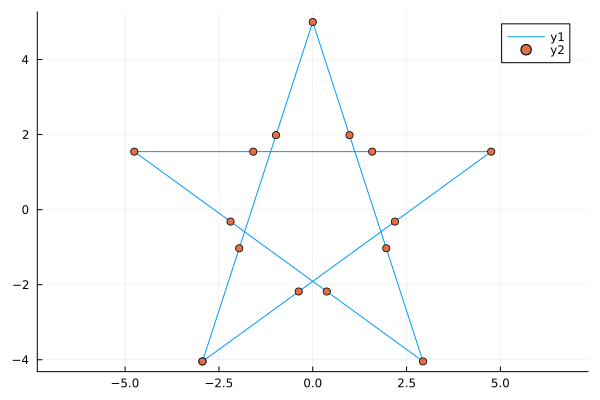

In [8]:
plot(x0[1,:],x0[2,:],aspect_ratio=:equal)
plot!(x0[1,:],x0[2,:],seriestype=:scatter)

In [9]:
xmin = zeros(ix);
xmax = [5,5,5, v_max,v_max,v_max, att_max,att_max,att_max, att_vel_max,att_vel_max,att_vel_max];
umin = zeros(iu);
umax = [F_max,M_max,M_max,M_max];
min_dt = 0.1;
max_dt = 10.0;
scaler = Scaling(xmin, xmax, umin, umax, tf0, min_dt,max_dt)
@assert max_dt * N >= tf0 

In [10]:
max_iter = 50;
w_tf = 2*1e0;
w_c = 0.0;
w_rate = 1e1;
w_param = 0.0;
w_vc = 1e2;
w_tr::Float64 = 5*1e1;
tol_vc = 1e-6;
tol_tr = 1e-3;
tol_dyn = 1e-1;
tr_norm = "quad";
verbosity = true;
# type_tf_free = "tf_free";
type_tf_free = "five_phase";

In [11]:
ptr = PTR(N,tf0,max_iter,dynamics,list_const,scaler,
    w_tf,w_c,w_rate,w_param,w_vc,w_tr,
    tol_vc,tol_tr,tol_dyn,
    tr_norm,verbosity,type_tf_free=type_tf_free)

PTR(QuadrotorDynamics(12, 4, 9, 7, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.325, 9.81, 0.03843, 0.02719, 0.060528), Constraint[QuadrotorConstraint(5.0, 1.0471975511965976, 3.141592653589793, 20.0, 3.0), QuadrotorMultiphaseConstraint(1, 4, 7, 10, 13, 16, [-2.938926261462365, -4.045084971874737], [3.061616997868383e-16, 5.0], [2.938926261462366, -4.045084971874737], [-4.755282581475767, 1.5450849718747375], [4.755282581475767, 1.545084971874737], 5.0)], Scaling([5.0 0.0 … 0.0 0.0; 0.0 5.0 … 0.0 0.0; … ; 0.0 0.0 … 3.141592653589793 0.0; 0.0 0.0 … 0.0 3.141592653589793], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.3183098861837907 0.0; 0.0 0.0 … 0.0 0.3183098861837907], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [20.0 

In [12]:
run(ptr,x0,u0,dt0,xi,xf,"Gurobi")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   main    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |125.13      |1.500     |2703.269    |0.000      |-1.000    |-1.5     | 0.4      |7.4e-01   |
|2      |295.63      |31.547    |3571.468    |0.013      |-1.000    |0.0      | 0.4      |1.4e+00   |
|3      |2579.75     |21.011    |2395.803    |0.555      |-1.000    |1.2      | 1.2      |1.2e+00   |
|4      |1103.07     |21.080    |2501.699    |1.582      |-1.000    |0.6      | 1.1      |1.0e+00 

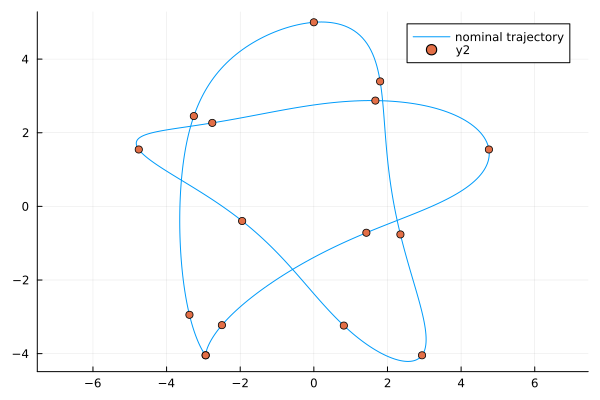

In [13]:
# plot(x0[1,:],x0[2,:],linestyle=:dash,aspect_ratio=:equal)
plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],aspect_ratio=:equal,label="nominal trajectory")
plot!(ptr.solution.x[1,:],ptr.solution.x[2,:],seriestype=:scatter)
# plot!(ptr.solution.x[1,:],ptr.solution.x[2,:])

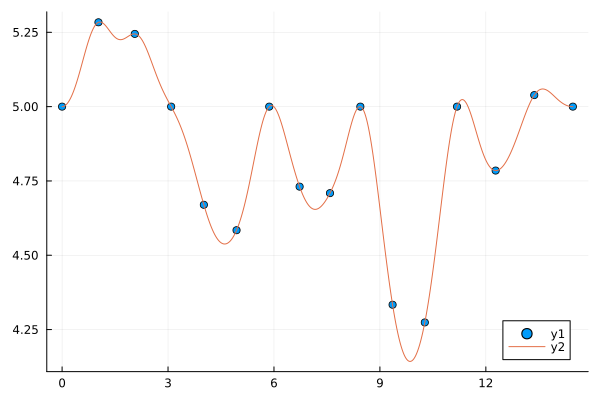

In [14]:
plot(ptr.solution.t,ptr.solution.x[3,:],seriestype=:scatter)
plot!(ptr.solution.tprop,ptr.solution.xprop[3,:])

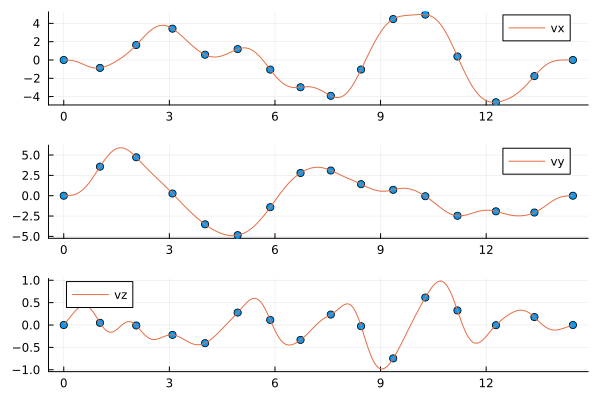

In [15]:
p1 = plot(ptr.solution.t,ptr.solution.x[4,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[4,:],label="vx")
p2 = plot(ptr.solution.t,ptr.solution.x[5,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[5,:],label="vy")
p3 = plot(ptr.solution.t,ptr.solution.x[6,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[6,:],label="vz")

plot(p1,p2,p3,layout=(3,1))

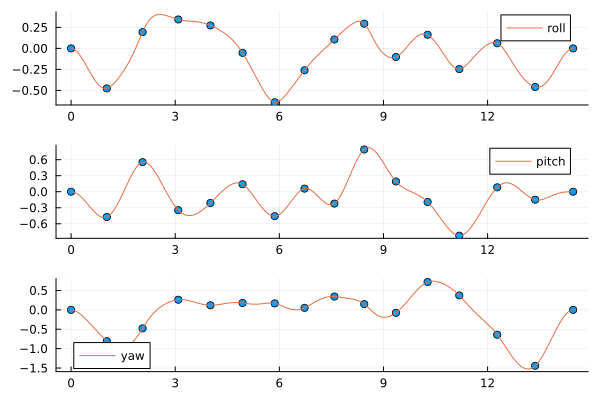

In [16]:
p1 = plot(ptr.solution.t,ptr.solution.x[7,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[7,:],label="roll")
p2 = plot(ptr.solution.t,ptr.solution.x[8,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[8,:],label="pitch")
p3 = plot(ptr.solution.t,ptr.solution.x[9,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[9,:],label="yaw")

plot(p1,p2,p3,layout=(3,1))

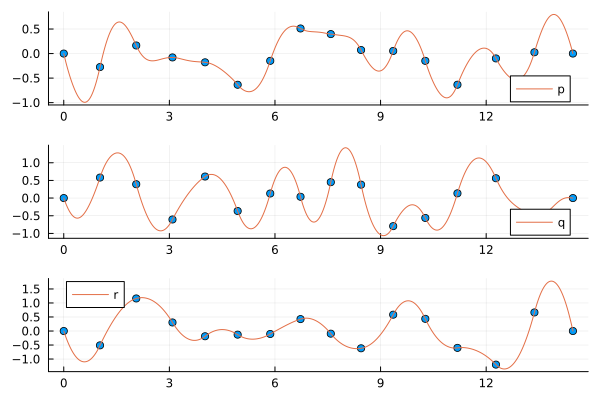

In [17]:
p1 = plot(ptr.solution.t,ptr.solution.x[10,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[10,:],label="p")
p2 = plot(ptr.solution.t,ptr.solution.x[11,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[11,:],label="q")
p3 = plot(ptr.solution.t,ptr.solution.x[12,:],seriestype = :scatter,label="")
plot!(ptr.solution.tprop,ptr.solution.xprop[12,:],label="r")

plot(p1,p2,p3,layout=(3,1))

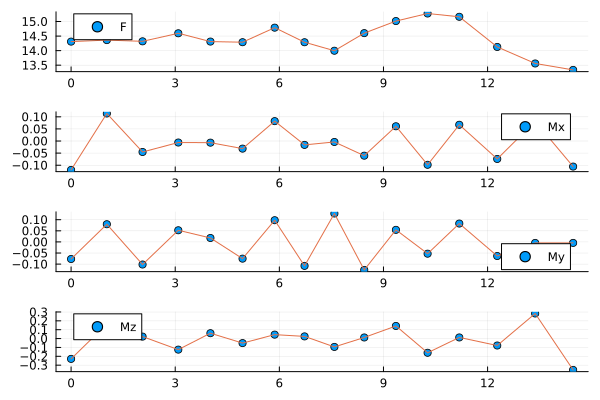

In [18]:
p1 = plot(ptr.solution.t,ptr.solution.u[1,:],seriestype = :scatter,label="F")
plot!(ptr.solution.t,ptr.solution.u[1,:],label="")
p2 = plot(ptr.solution.t,ptr.solution.u[2,:],seriestype = :scatter,label="Mx")
plot!(ptr.solution.t,ptr.solution.u[2,:],label="")
p3 = plot(ptr.solution.t,ptr.solution.u[3,:],seriestype = :scatter,label="My")
plot!(ptr.solution.t,ptr.solution.u[3,:],label="")
p4 = plot(ptr.solution.t,ptr.solution.u[4,:],seriestype = :scatter,label="Mz")
plot!(ptr.solution.t,ptr.solution.u[4,:],label="")

plot(p1,p2,p3,p4,layout=(4,1))

In [19]:
# using JLD2, FileIO
# my_dict = Dict("x" => ptr.solution.x, "u" => ptr.solution.u, "t" => ptr.solution.t)
# @save "./data/nominal_traj_quad_star_0713" my_dict